# Практическое задание 7. 

## Разработка рекомендательной системы на Python

**Инструкция:**

- Шаг 1. Постройте рекомендательную систему на примере данных о покупках. Исходные файлы: praktika_7.csv - пользовательские транзакции
   
Имя файла | Ссылка
-- | --
praktika_7.csv | https://github.com/OlesiaAngel/DataAnalitics/blob/main/%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5/recomend/praktika_7.csv?raw=true

- Шаг 2. Реализуйте коллаборативную фильтрацию данных на основе пользователей. Используйте модель kNN. Проверить модель на покупателях с customer_id = 4 и customer_id = 21.
- Шаг 3. Опубликуйте файл расширения ipynb на платформе Odin.

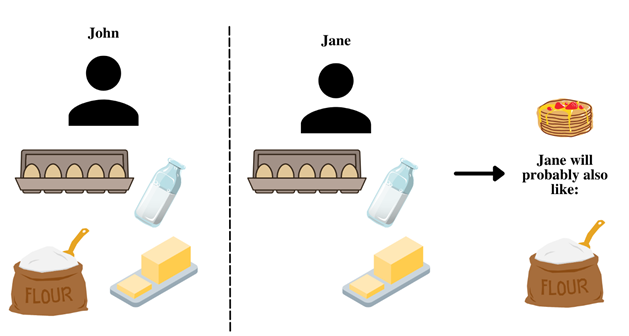

У сети продуктовых магазинов разрабатывается новое мобильное приложение, позволяющее покупателям размещать заказы еще до того, как они зайдут в магазин.

В приложении должна быть возможность показывать рекомендации: когда покупатель впервые нажимает на страницу «заказ», мы можем порекомендовать добавить в его корзину 10 лучших товаров, например, одноразовую посуду, свежее мясо, чипсы и т. д.

**Цель работы: получить список рекомендаций для указанного пользователя**, например:

Входные данные: идентификатор клиента

Результат: ранжированный список товаров (идентификаторов продуктов), которые пользователь, скорее всего, захочет положить в свою (пустую) «корзину».

In [1]:
# подключение библиотек
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from surprise import Dataset, Reader
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import accuracy
from surprise.prediction_algorithms.knns import KNNBasic

import warnings
warnings.filterwarnings('ignore')



In [2]:
# Подключение анализируемого файла
df_products = pd.read_csv('https://github.com/OlesiaAngel/DataAnalitics/blob/main/%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5/recomend/praktika_7.csv?raw=true'
)
df_products.head()                        

,Unnamed: 0,customerId,productId,purchase_count
0,0,0,1,2
1,1,0,13,1
2,2,0,19,3
3,3,0,20,1
4,4,0,31,2


In [3]:
#Получение информации о файле
df_products.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133585 entries, 0 to 133584
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   Unnamed: 0      133585 non-null  int64
 1   customerId      133585 non-null  int64
 2   productId       133585 non-null  int64
 3   purchase_count  133585 non-null  int64
dtypes: int64(4)
memory usage: 4.1 MB


In [4]:
#Выполнение проверки  на  наличие пустых значений
df_products.isnull().sum()

Unnamed: 0        0
customerId        0
productId         0
purchase_count    0
dtype: int64

In [5]:
# Удаление лишнего сттолбца и  визуальная проверка удаления
df = df_products[['customerId','productId','purchase_count']]
df.head()

,customerId,productId,purchase_count
0,0,1,2
1,0,13,1
2,0,19,3
3,0,20,1
4,0,31,2


In [6]:
# Переименование столбцов и  визуальная проверка переименования
df.columns = ['user','item','rating']
df.head()

,user,item,rating
0,0,1,2
1,0,13,1
2,0,19,3
3,0,20,1
4,0,31,2


In [7]:
#построение матрицы
from scipy.sparse import csr_matrix 
df_matrix = df.pivot(index='user', columns='item', values='rating').fillna(0)
w1_pivot_matrix = csr_matrix(df_matrix)

In [8]:
#подключение метода косинусов
from sklearn.neighbors import NearestNeighbors  
knn = NearestNeighbors(n_neighbors=10, algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(w1_pivot_matrix)

In [9]:
# Чтение файла
reader = Reader(line_format='user item rating', sep=',', rating_scale=(0,5), skip_lines=1)
data = Dataset.load_from_df( df.iloc[:1000,:], reader=reader) #  недостаток вычислительной мощности 
trainset = data.build_full_trainset()

In [10]:
# Параметры сходства
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN 
sim_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=33)

sim_user.fit(trainset)

In [11]:
# Определение функции для формирования рекомендаций
def get_recommendations(data, user_id, top_n, algo):
    recommendations = []
    user_movie_interactions_matrix = data.pivot(index='user', columns='item', values='rating')
    non_interacted_movies = user_movie_interactions_matrix.loc[user_id][user_movie_interactions_matrix.loc[user_id].isnull()].index.tolist()
    for item_id in non_interacted_movies:
        est = algo.predict(user_id, item_id).est
        recommendations.append((item_id, est))
    recommendations.sort(key=lambda x: x[1], reverse=True)
    return recommendations[:top_n] 

In [12]:
# Рекомендации для покупателя id=4
get_recommendations(df, 4, 10, sim_user)

[(94, 5),
 (144, 5),
 (248, 5),
 (62, 4.0),
 (66, 4.0),
 (231, 3.5),
 (2, 3.199211026104995),
 (18, 3.1666666666666665),
 (12, 3.0),
 (34, 3.0)]

In [13]:
# Рекомендации для покупателя id=21
get_recommendations(df, 21, 10, sim_user)

[(18, 5),
 (30, 5),
 (94, 5),
 (241, 5),
 (248, 5),
 (279, 5),
 (177, 4.379472707826255),
 (97, 4.0),
 (11, 3.9560706807386126),
 (0, 3.8264795430092815)]